In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

files = os.listdir("C:/Users/pc/Desktop/binaryDS/train_images")

img_list=[]
for i in files:
    image = cv2.imread(f"C:/Users/pc/Desktop/binaryDS/train_images/{i}")
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thold = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kenar = cv2.findContours(thold.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kenar = kenar[0][0]
    kenar = kenar[:,0,:]
    x1 = tuple(kenar[kenar[:,0].argmin()])[0]
    y1 = tuple(kenar[kenar[:,1].argmin()])[1]
    x2 = tuple(kenar[kenar[:,0].argmax()])[0]
    y2 = tuple(kenar[kenar[:,1].argmin()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*4//50
    kopya2 = image.copy()
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    med_resim = cv2.medianBlur(son,3)
    arka_plan = cv2.medianBlur(son,33)
    maske = cv2.addWeighted(med_resim,1,arka_plan,-1,255)
    maske_resim = cv2.bitwise_and(maske,med_resim)
    img_list.append(maske_resim)
    

In [2]:
df = pd.read_csv("C:/Users/pc/Desktop/binaryDS/train.csv")
print(df.head())

        id_code  diagnosis
0  000c1434d8d7          1
1  001639a390f0          1
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [3]:
y_train = pd.get_dummies(df["diagnosis"]).values.astype(int)

In [4]:
import numpy as np

x_train = np.array(img_list)

In [5]:
x_train.shape

(3662, 400, 400, 3)

In [6]:
y_train.shape

(3662, 2)

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.15,random_state=42,shuffle = True)

In [8]:
print(f'Eğitim Seti Boyutu: {x_train.shape}')
print(f'Test Seti Boyutu: {x_test.shape}')

Eğitim Seti Boyutu: (3112, 400, 400, 3)
Test Seti Boyutu: (550, 400, 400, 3)


In [9]:
y_train_binary = np.argmax(y_train, axis=1)  # 0 veya 1'e dönüştürür
y_test_binary = np.argmax(y_test, axis=1)  # 0 veya 1'e dönüştürür

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications.efficientnet import preprocess_input

# EfficientNetB5 modeli yükle
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

# Sadece son 30 katmanı eğitilebilir yap
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Model mimarisi
inputs = tf.keras.Input(shape=(400, 400, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)  # Batch normalization ekledim
x = layers.Dense(512, activation='relu')(x)  # Ekstra katman ekledim
x = layers.Dropout(0.4)(x)  # Dropout'u 0.4 olarak optimize ettim
outputs = layers.Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

# AdamW optimizasyonu
model.compile(optimizer=AdamW(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Veri artırma işlemleri
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,  # Dikey çevirme eklendi
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = valid_datagen.flow(x_test, y_test, batch_size=16)

# Modeli eğitme
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

C:\Users\pc\conda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1654s 8s/step - accuracy: 0.8155 - loss: 0.4625 - val_accuracy: 0.8945 - val_loss: 0.3020
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1560s 8s/step - accuracy: 0.9304 - loss: 0.2143 - val_accuracy: 0.9345 - val_loss: 0.1600
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1564s 8s/step - accuracy: 0.9384 - loss: 0.1649 - val_accuracy: 0.9327 - val_loss: 0.1700
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1525s 8s/step - accuracy: 0.9455 - loss: 0.1581 - val_accuracy: 0.9655 - val_loss: 0.1009
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1559s 8s/step - accuracy: 0.9416 - loss: 0.1616 - val_accuracy: 0.9618 - val_loss: 0.1162
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1562s 8s/step - accuracy: 0.9488 - loss: 0.1560 - val_accuracy: 0.9000 - val_loss: 0.3151
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1549s 8s/step - accuracy: 0.9518 - loss: 0.1259 - val_accuracy: 0.9582 - val_loss: 0.1099
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1559s 8s/step - accuracy: 0.9489 - loss: 0.1495 - 

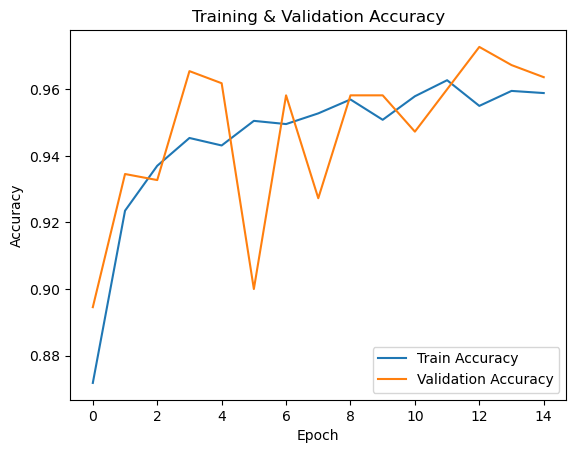

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

In [12]:

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

y_pred_probs = model.predict(x_test) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1) 

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# TN, FP, FN, TP 
if cm.shape == (2,2):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
else:
    specificity = "Only for binary classification"

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Sensitivity (Recall)
sensitivity = recall_score(y_true, y_pred, average='macro')  # Multi-class için 'macro' kullanıyoruz

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity}")
print(f"MCC: {mcc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 197s 11s/step
Confusion Matrix:
[[260   3]
 [ 17 270]]
Accuracy: 0.9636
Sensitivity (Recall): 0.9647
Specificity: 0.9885931558935361
MCC: 0.9285
